<a href="https://colab.research.google.com/github/HumaSatti/Depression-Detection-By-ML-Deep-Learning-Model/blob/main/Nurse_prediction_deep_leraning_model_small_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'nurse-stress-prediction-wearable-sensors:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4110234%2F7125235%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240624%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240624T121055Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D6c712ab131a354fb064bb975282df274cd1a85de4647fc17791e0d2b2881da9ce472d950fdafed9aec59f234975b158ada3cdfc7beabae28d7f50f4e1c90eeb30febff7306c8f59e4d3001519a134fd56810d83d02a3964c39fa2fa1e16b10639c1dbc84e8e6fb30a20602521fec7b1509e81263a9689e86c5b7f525a432d76a51023568c6bbde0c731714a3d80529cbb65f78e698398885c7c0d0dcf3f99946277ab35b0a02bad755706ef4af1fc47fbb4f3e20d7f15bb82154f154dd1b0c6b0a1270b4a18e690d7899896c72a76591f29f641180ca530432be490db57e016111b3c5a00c3c9f2974a083bc4aca3b1db9e348c3e9a1d3312b73b07ce6c46afa'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 79877492 bytes downloaded
Downloaded and uncompressed: nurse-stress-prediction-wearable-sensors
Data source import complete.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nurse-stress-prediction-wearable-sensors/merged_data.csv


In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf

In [4]:
# Load the dataset
df = pd.read_csv('/kaggle/input/nurse-stress-prediction-wearable-sensors/merged_data.csv', low_memory=False, parse_dates=['datetime'])
df

,X,Y,Z,EDA,HR,TEMP,id,datetime,label
0,-13.0,-61.0,5.0,6.769995,99.43,31.17,15,2020-07-08 14:03:00.000000000,2.0
1,-20.0,-69.0,-3.0,6.769995,99.43,31.17,15,2020-07-08 14:03:00.031249920,2.0
2,-31.0,-78.0,-15.0,6.769995,99.43,31.17,15,2020-07-08 14:03:00.062500096,2.0
3,-47.0,-65.0,-38.0,6.769995,99.43,31.17,15,2020-07-08 14:03:00.093750016,2.0
4,-67.0,-57.0,-53.0,6.769995,99.43,31.17,15,2020-07-08 14:03:00.124999936,2.0
...,...,...,...,...,...,...,...,...,...
11509046,-16.0,-56.0,24.0,3.386070,88.37,33.77,F5,2020-07-23 17:28:59.875000064,2.0
11509047,-8.0,-50.0,27.0,3.386070,88.37,33.77,F5,2020-07-23 17:28:59.906249984,2.0
11509048,-28.0,-36.0,28.0,3.386070,88.37,33.77,F5,2020-07-23 17:28:59.937499904,2.0
11509049,-29.0,-29.0,30.0,3.386070,88.37,33.77,F5,2020-07-23 17:28:59.968750080,2.0


In [5]:

# Remove duplicates and handle missing values
df.drop_duplicates(inplace=True)
df.dropna(inplace=True)

In [6]:
# Extract datetime features
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['hour'] = df['datetime'].dt.hour
df['minute'] = df['datetime'].dt.minute
df['second'] = df['datetime'].dt.second

In [7]:
# Drop unnecessary columns
df.drop(['datetime', 'id'], axis=1, inplace=True)

In [8]:
# Separate features and target
X = df.drop('label', axis=1)
y = df['label']

In [9]:
# Sample a subset of the data for initial training (e.g., 1% of the data)
sample_frac = 0.01
X_sampled, _, y_sampled, _ = train_test_split(X, y, test_size=1-sample_frac, stratify=y, random_state=42)


In [10]:
# Handle imbalanced data
over_sample = RandomOverSampler(random_state=42)
X_sampled, y_sampled = over_sample.fit_resample(X_sampled, y_sampled)


In [11]:
# Split the sampled dataset into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X_sampled, y_sampled, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [12]:
# Scale the features
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)


In [13]:
# Set up the strategy for TPU/CPU/GPU
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy()  # Default strategy for CPU and GPU


In [14]:
# Build the model inside the strategy scope
with strategy.scope():
    model = Sequential([
        Input(shape=(X_train.shape[1],)),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(32, activation='relu'),
        Dense(3, activation='softmax')  # Adjust the output layer according to your number of classes
    ])


In [15]:
 model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [16]:
# Set up callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', mode='min')


In [17]:
# Train the model
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), callbacks=[early_stopping, checkpoint])


Epoch 1/50
6351/6351 [==============================] - 26s 4ms/step - loss: 0.5252 - accuracy: 0.7647 - val_loss: 0.2672 - val_accuracy: 0.8954
Epoch 2/50
6351/6351 [==============================] - 18s 3ms/step - loss: 0.3042 - accuracy: 0.8796 - val_loss: 0.1801 - val_accuracy: 0.9342
Epoch 3/50
6351/6351 [==============================] - 22s 3ms/step - loss: 0.2541 - accuracy: 0.9026 - val_loss: 0.1565 - val_accuracy: 0.9462
Epoch 4/50
6351/6351 [==============================] - 20s 3ms/step - loss: 0.2308 - accuracy: 0.9119 - val_loss: 0.1322 - val_accuracy: 0.9529
Epoch 5/50
6351/6351 [==============================] - 21s 3ms/step - loss: 0.2135 - accuracy: 0.9190 - val_loss: 0.1131 - val_accuracy: 0.9583
Epoch 6/50
6351/6351 [==============================] - 19s 3ms/step - loss: 0.2015 - accuracy: 0.9219 - val_loss: 0.1106 - val_accuracy: 0.9558
Epoch 7/50
6351/6351 [==============================] - 21s 3ms/step - loss: 0.1934 - accuracy: 0.9251 - val_loss: 0.0995 - val_ac

In [18]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')


794/794 [==============================] - 2s 3ms/step - loss: 0.0392 - accuracy: 0.9878
Test Loss: 0.039150968194007874, Test Accuracy: 0.9877967238426208


In [19]:
# Predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)


794/794 [==============================] - 2s 2ms/step


In [20]:
# Classification report
print(classification_report(y_test, y_pred_classes))


              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98      8522
         1.0       0.99      1.00      1.00      8391
         2.0       0.99      0.97      0.98      8490

    accuracy                           0.99     25403
   macro avg       0.99      0.99      0.99     25403
weighted avg       0.99      0.99      0.99     25403



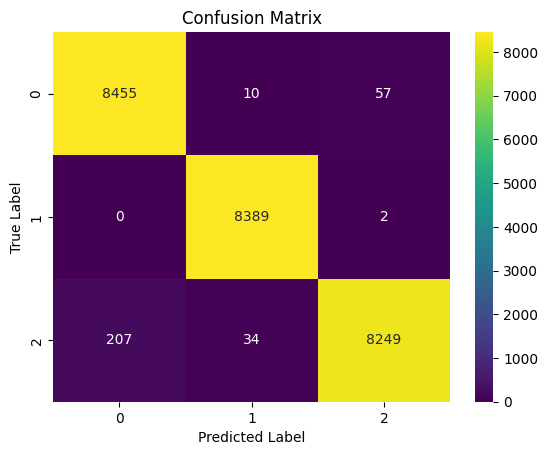

In [22]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

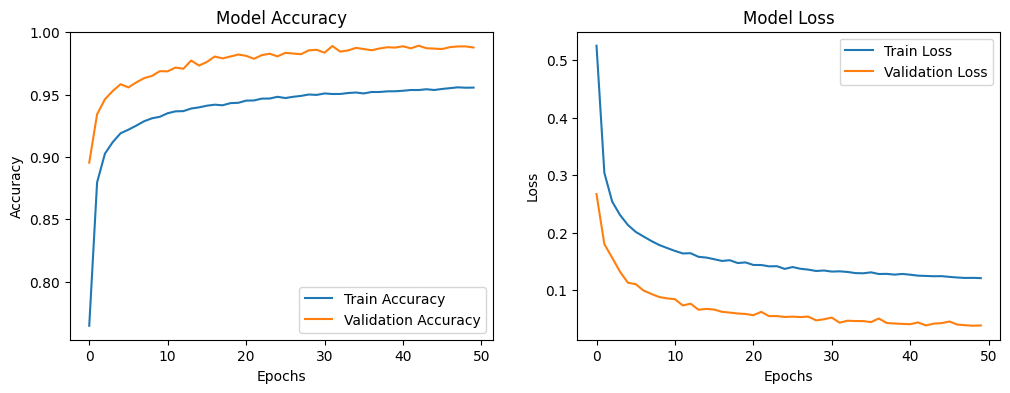

In [23]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()